### Bird Attribute Model Analysis
File: model_analysis.ipynb\
Author: Cole Stokes\
Date: 2024-11-28\
Last Modified: 2024-11-30\
Description: Displays data visulizations of the model performance and dataset.

Metrics Setup

In [1]:
# Install packages not in Jupyter
pip install scikit-learn

SyntaxError: invalid syntax (619478042.py, line 2)

In [2]:
# Import libraries
import ast
from attribute_detector import AttributeCNN
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader
from utils import calculate_metrics, LoadData

In [3]:
# Read the CSV files
metrics_3_5 = pd.read_csv("model_metrics_3.5.csv")
metrics_5_0 = pd.read_csv("model_metrics_5.0.csv")

Plot Metrics

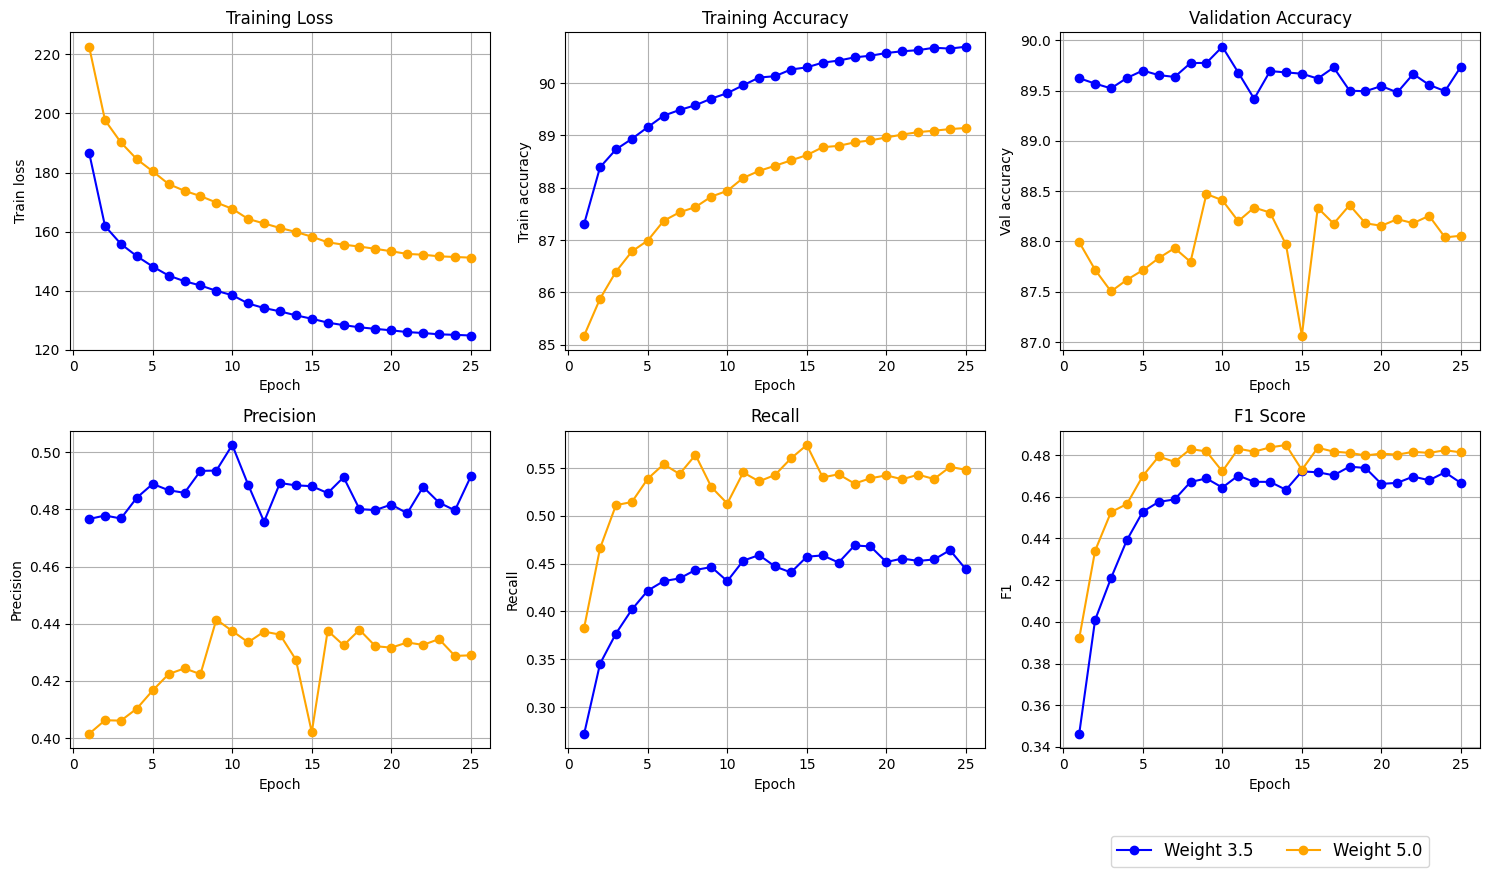

In [4]:
epochs_3_5 = metrics_3_5['epoch']
epochs_5_0 = metrics_5_0['epoch']

# Metrics and titles
metrics = ['train_loss', 'train_accuracy', 'val_accuracy', 'precision', 'recall', 'f1']
titles = {
    'train_loss': 'Training Loss',
    'train_accuracy': 'Training Accuracy',
    'val_accuracy': 'Validation Accuracy',
    'precision': 'Precision',
    'recall': 'Recall',
    'f1': 'F1 Score'
}
colors = {'3.5': 'blue', '5.0': 'orange'}

# Create each plot
plt.figure(figsize=(15, 10))
for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 3, i)
    plt.plot(epochs_3_5, metrics_3_5[metric], label='Weight 3.5', color=colors['3.5'], marker='o')
    plt.plot(epochs_5_0, metrics_5_0[metric], label='Weight 5.0', color=colors['5.0'], marker='o')
    plt.title(titles[metric])
    plt.xlabel('Epoch')
    plt.ylabel(metric.replace('_', ' ').capitalize())
    plt.grid(True)

# Add legend
plt.legend(['Weight 3.5', 'Weight 5.0'], loc='lower center', bbox_to_anchor=(0.5, -0.4), ncol=2, fontsize=12)

# Shows plots
plt.tight_layout(rect=[0, 0.1, 1, 1])
plt.show()

Attribute Subcategory Setup

In [5]:
# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get validation data
data = pd.read_csv("cub_200_2011.csv")
_, val_data = train_test_split(data, train_size=0.8, random_state=200)

# Get attributes
attributes = pd.read_csv("CUB_200_2011/attributes.txt", delimiter=" ", header=None)
attributes_list = attributes[1].tolist()

In [6]:
# Creates a dictionary of the attribute subcategories
attribute_category_dict = {}

i = 0
for attribute in attributes_list:
    category = attribute.split("::")[0]
    if category in attribute_category_dict.keys():
        attribute_category_dict[category][1] = i
    else:
        attribute_category_dict[category] = [i, i]
    i += 1

Subcategory Imbalance Setup and Display

In [7]:
# Create an attribute matrix
attribute_matrix = [ast.literal_eval(lst) for lst in data["attributes"]]

# Sum up the columns and divide by the length
attribute_proportions = (np.sum(attribute_matrix, axis=0) / len(attribute_matrix)).tolist()

# Group the attributes by subcategory and divide by it's length
subcategory_proportions = []

for lst in attribute_category_dict.values():
    subcategory = attribute_proportions[lst[0]:lst[1]+1]
    subcategory_proportions.append(subcategory)

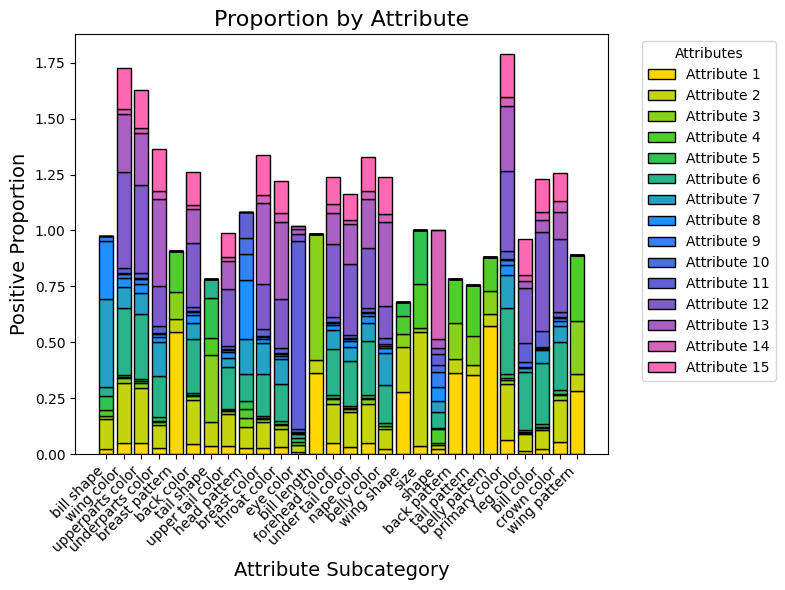

In [8]:
# Create labels
labels = [" ".join(key.split("_")[1:]) for key in attribute_category_dict.keys()]
num_bars = len(subcategory_proportions)
x_positions = range(num_bars)
bottoms = np.zeros(num_bars)

# Setup colors
cmap = LinearSegmentedColormap.from_list(
    "colors", ["#FFD700", "#32CD32", "#1E90FF", "#6A5ACD", "#FF69B4"], N=15
)
colors = [cmap(i / 14) for i in range(15)]

# Create the stacked bar chart
plt.figure(figsize=(8, 6))
for i in range(max(len(category) for category in subcategory_proportions)):
    stack_values = [category[i] if i < len(category) else 0 for category in subcategory_proportions]
    plt.bar(x_positions, stack_values, bottom=bottoms, color=colors[i], label=f"Attribute {i+1}", edgecolor='black')
    bottoms += stack_values

# Add labels, title, and legend
plt.title("Proportion by Attribute", fontsize=16)
plt.xlabel("Attribute Subcategory", fontsize=14)
plt.ylabel("Positive Proportion", fontsize=14)
plt.xticks(x_positions, labels=[label for label in labels], rotation=45, ha='right')
plt.legend(title="Attributes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Show the plot
plt.show()

Subcategory Metrics Setup

In [9]:
# Loads the best model.
model = AttributeCNN()
model.load_state_dict(torch.load("models/weight_5.0/attribute_cnn_epoch_14.pth", weights_only=True)["model_state_dict"])
model.eval()

AttributeCNN(
  (conv_blocks): Sequential(
    (0): ConvBlock(
      (conv_block): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
      )
      (skip): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
      (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): ConvBlock(
      (conv_block): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, 

In [10]:
# Splits into subcategory DataFrames for analysis
category_df_list = []

for lst in attribute_category_dict.values():
    val_data_section = val_data.copy()
    val_data_section["attributes"] = val_data_section["attributes"].apply(lambda x: str(ast.literal_eval(x)[lst[0]:lst[1]+1]))
    val_loader = DataLoader(LoadData(val_data_section), batch_size=1, shuffle=False)
    category_df_list.append(calculate_metrics(model, val_loader, device, range=lst))

Plots Subcategory Statistics

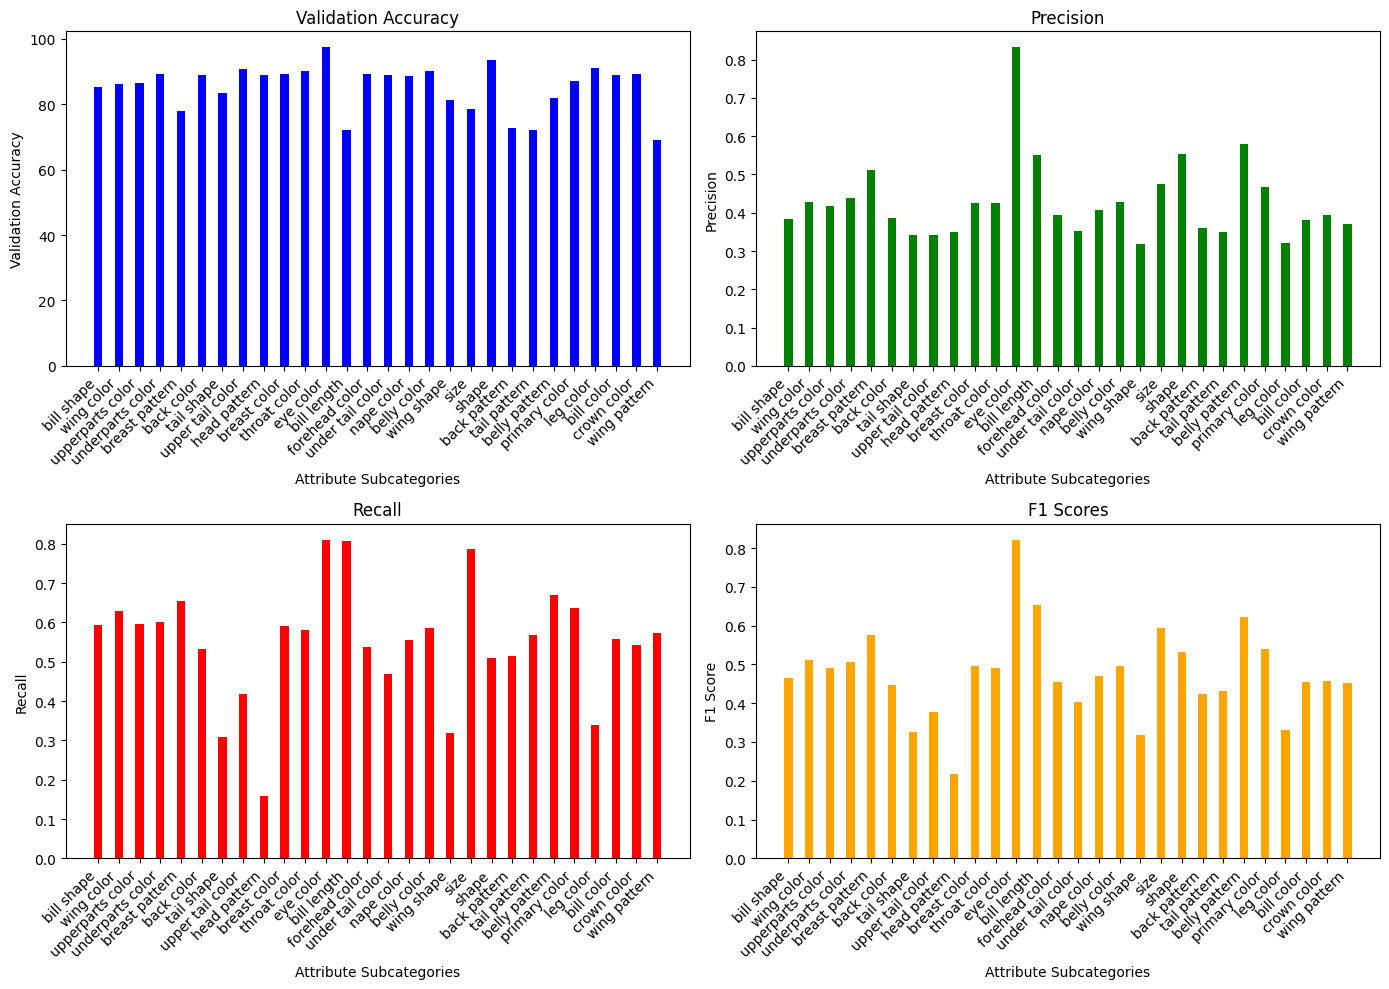

In [11]:
# Gets values
val_accs = [i[0] for i in category_df_list] 
precisions = [i[1] for i in category_df_list] 
recalls = [i[2] for i in category_df_list] 
f1_scores = [i[3] for i in category_df_list]  

# Generates labels
x_labels = [" ".join(key.split("_")[1:]) for key in attribute_category_dict.keys()]

x = range(len(category_df_list))

# Create the figure and axes for each subplot
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plots validation accuracy
axes[0, 0].bar(x, val_accs, width=0.4, color='blue')
axes[0, 0].set_xlabel("Attribute Subcategories")
axes[0, 0].set_ylabel("Validation Accuracy")
axes[0, 0].set_title("Validation Accuracy")
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(x_labels, rotation=45, ha='right')

# Plots precision
axes[0, 1].bar(x, precisions, width=0.4, color='green')
axes[0, 1].set_xlabel("Attribute Subcategories")
axes[0, 1].set_ylabel("Precision")
axes[0, 1].set_title("Precision")
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(x_labels, rotation=45, ha='right')

# Plots recall
axes[1, 0].bar(x, recalls, width=0.4, color='red')
axes[1, 0].set_xlabel("Attribute Subcategories")
axes[1, 0].set_ylabel("Recall")
axes[1, 0].set_title("Recall")
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(x_labels, rotation=45, ha='right')

# Plots F1
axes[1, 1].bar(x, f1_scores, width=0.4, color='orange')
axes[1, 1].set_xlabel("Attribute Subcategories")
axes[1, 1].set_ylabel("F1 Score")
axes[1, 1].set_title("F1 Scores")
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(x_labels, rotation=45, ha='right')

# Shows plots
plt.tight_layout()
plt.show()